In [16]:
import pandas as pd
import plotly.graph_objects as go
import torch

from darts.dataprocessing.transformers import Scaler

In [17]:
df = pd.read_excel('dataset/kawaldata_clean.xlsx', parse_dates=True)
df.head()

,Unnamed: 0,tanggal,Kasus harian,Total kasus,Kasus aktif,Sembuh\n(baru),Sembuh,Meninggal\n(baru),Meninggal\nDunia,Tingkat kematian (seluruh kasus),...,Unnamed: 41,Dosis pertama,Dosis kedua,Dosis ketiga,Dosis pertama (%),Dosis kedua (%),Dosis pertama (harian),Dosis kedua (harian),Dosis harian,Dosis pertama (mingguan)
0,0,2020-03-02,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2020-03-03,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2020-03-04,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2020-03-05,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2020-03-06,2.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **COVID-19 Indonesia Statistics**

In [18]:
df_stats = pd.concat([df['tanggal'], df['Kasus harian'], df['Meninggal\n(baru)'], df['Sembuh\n(baru)']], axis=1)
df_stats = df_stats.loc[(df.tanggal >= "2021-01-27")]
df_stats = df_stats.dropna()

print(f'Total Statistic Days {len(df_stats)}')

Total Statistic Days 208


In [19]:
line_stat = []
line_stat.append(go.Scatter(x=df_stats.tanggal, y=df_stats['Kasus harian'], name="Kasus Harian", mode='lines'))
line_stat.append(go.Scatter(x=df_stats.tanggal, y=df_stats['Sembuh\n(baru)'], name="Sembuh", mode='lines'))

fig = go.Figure(data=line_stat)
fig.update_layout(title_text="COVID-19 Case Indonesia")
fig.show()

## **Vaccination Indonesia Statistics**

In [20]:
df_vaccine = pd.concat([df['tanggal'], df['Dosis pertama (harian)'], df['Dosis kedua (harian)']], axis=1)
df_vaccine = df_vaccine.loc[(df.tanggal >= "2021-01-27")]
df_vaccine = df_vaccine.dropna()
df_vaccine.head()

,tanggal,Dosis pertama (harian),Dosis kedua (harian)
330,2021-01-27,62318.0,66.0
331,2021-01-28,60315.0,5402.0
332,2021-01-29,36694.0,5819.0
333,2021-01-30,77133.0,9523.0
334,2021-01-31,10988.0,1738.0


In [21]:
line_stat = []
line_stat.append(go.Scatter(x=df_vaccine.tanggal, y=df_vaccine['Dosis pertama (harian)'], name="Dosis Pertama", mode='lines'))
line_stat.append(go.Scatter(x=df_vaccine.tanggal, y=df_vaccine['Dosis kedua (harian)'], name="Dosis Kedua", mode='lines'))


fig = go.Figure(data=line_stat)
fig.update_layout(title_text="Vaccination Indonesia")
fig.show()

In [22]:
df_mobility = pd.read_csv("dataset/movement_clean.csv")
df_mobility = df_mobility.dropna()
df_mobility.head()

,Unnamed: 0,ds,all_day_bing_tiles_visited_relative_change
0,0,2021-01-27,-49.58906
1,1,2021-01-28,-50.31779
2,2,2021-01-29,-51.04879
3,3,2021-01-30,-50.74521
4,4,2021-01-31,-54.34471


In [23]:
len(df_mobility)

207

In [24]:
line_stat = []
line_stat.append(go.Scatter(x=df_mobility.ds,
                            y=df_mobility['all_day_bing_tiles_visited_relative_change'], name="Retail And Recreation", mode='lines'))

fig = go.Figure(data=line_stat)
fig.update_layout(title_text="Indonesia Mobility")
fig.show()


In [25]:
df_bobot = pd.read_csv('dataset/bobot_2021.csv')
df_bobot = df_bobot.loc[(df_bobot.date >= "2021-01-27") & (df_bobot.date <= "2021-08-21")]
df_bobot.head()


,Unnamed: 0,date,bobot
26,26,2021-01-27,0.0
27,27,2021-01-28,0.0
28,28,2021-01-29,0.0
29,29,2021-01-30,0.0
30,30,2021-01-31,0.0


In [26]:
len(df_bobot)

207

## **Time Series Feature Engineering**

- Drop Tanggal, Dosis kedua (harian) Column In df_vaccine
- Drop Meninggal Column In df_stats
- Filling NaN Value With 0
- Seperating Train Variable With Date

In [27]:
df_vaccine = df_vaccine.drop(columns=['tanggal', 'Dosis pertama (harian)'], axis=1)
df_mobility = df_mobility.drop(columns=['ds', 'Unnamed: 0'], axis=1)
df_stats = df_stats.drop(columns=['Meninggal\n(baru)'], axis=1)
df_bobot = df_bobot.drop(columns=['Unnamed: 0', 'date'])


In [28]:
df_timeseries = pd.concat([
       df_stats.reset_index(drop=True),
       df_vaccine.reset_index(drop=True), 
       df_mobility.reset_index(drop=True),
       df_bobot.reset_index(drop=True)
], axis=1)

df_timeseries = df_timeseries.dropna()


In [29]:
df_timeseries.tail()


,tanggal,Kasus harian,Sembuh\n(baru),Dosis kedua (harian),all_day_bing_tiles_visited_relative_change,bobot
202,2021-08-17,20741.0,32225.0,243799.0,-69.36412,0.7
203,2021-08-18,15768.0,29794.0,674333.0,-32.22304,0.7
204,2021-08-19,22053.0,29012.0,702847.0,-35.43749,0.7
205,2021-08-20,20004.0,26122.0,355245.0,-41.58287,0.0
206,2021-08-21,16744.0,23011.0,619482.0,-45.64792,0.0


In [30]:
variable = df_timeseries.loc[:, df_timeseries.columns != 'tanggal']
variable = list(variable)
variable

['Kasus harian',
 'Sembuh\n(baru)',
 'Dosis kedua (harian)',
 'all_day_bing_tiles_visited_relative_change',
 'bobot']

## **Time Series Modelling**

In [122]:
from darts import TimeSeries

scaler = Scaler()
series = scaler.fit_transform(TimeSeries.from_dataframe(df_timeseries, 'tanggal', variable))

train, val = series.split_after(pd.Timestamp("2021-07-01"))
# series = scaler.fit_transform(train)
train = series
val = scaler.fit_transform(val)


In [32]:
from darts.models import NBEATSModel

model = NBEATSModel(
    input_chunk_length=12,
    output_chunk_length=5,
    generic_architecture=True,
    num_stacks=8,
    num_blocks=6,
    num_layers=6,
    layer_widths=512,
    n_epochs=200,
    batch_size=500,
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model.fit(train, val_series=val, verbose=True)


[2021-08-23 21:25:05,588] INFO | darts.models.torch_forecasting_model | Train dataset contains 191 samples.
[2021-08-23 21:25:05,588] INFO | darts.models.torch_forecasting_model | Train dataset contains 191 samples.


cuda:0


  0%|          | 0/200 [00:00<?, ?it/s]

## **Historical Prediction - Last Month** 

In [33]:
pred_series = model.historical_forecasts(
    train,
    start=pd.Timestamp("2021-03-20"),
    retrain=False,
    verbose=True
)

  0%|          | 0/155 [00:00<?, ?it/s]

R2 Score: 0.9920624002014715


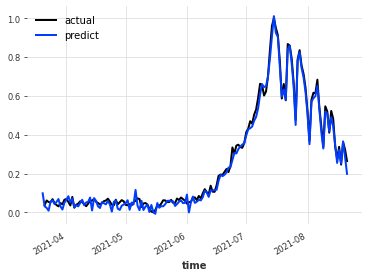

In [34]:
from darts.metrics import r2_score
ts_transformed = train.drop_before(pd.Timestamp("2021-03-20"))

ts_transformed['0'].univariate_component(0).plot(label='actual')
pred_series['0'].plot(label='predict')

print('R2 Score:', r2_score(ts_transformed.univariate_component(0), pred_series['0']))

## **Future Prediction**

In [123]:
prediction = model.predict(500)
prediction = prediction.pd_dataframe()


In [124]:
series = series.pd_dataframe()

In [125]:
from datetime import date

min_case = prediction[['0']].idxmin()
min_case = date(2021, 8, 17) - min_case[0].date()
min_case = abs(min_case.days)

dates = list(pd.date_range(start="2021-08-20", periods=min_case))

In [126]:
min_case = date(2021, 8, 21) - date(2021, 10, 23)
min_case = abs(min_case.days)
dates = list(pd.date_range(start="2021-08-22", periods=min_case))

In [127]:
prediction = prediction.reset_index()
series = series.reset_index()

for i, col in enumerate(variable):
    prediction = prediction.rename(columns={'{}'.format(i) : col})
    series = series.rename(columns={'{}'.format(i): col})

In [131]:
line_stat = []

for x in range(0, 2):
    line_stat.append(go.Scatter(x=df_timeseries.tanggal, y=series[variable[x]], name=variable[x], mode='lines'))
    line_stat.append(go.Scatter(x=dates, y=prediction[variable[x]], name=f'Forecast {variable[x]}', mode='lines'))

fig = go.Figure(data=line_stat)
fig.update_layout(title_text=f"Predict COVID-19 Indonesia Within {min_case} Days Periods")
fig.show()


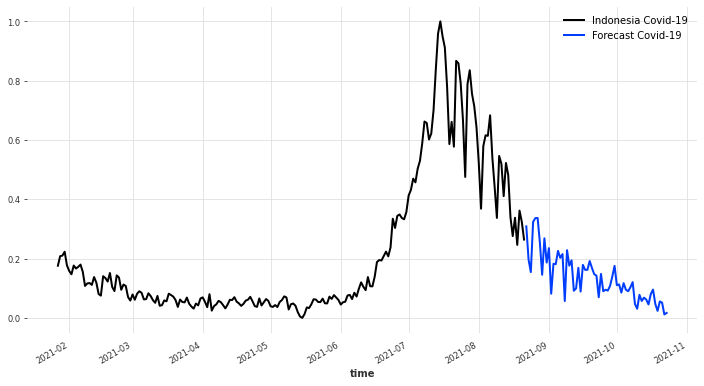

In [132]:
import matplotlib.pyplot as plt

prediction = model.predict(min_case)
plt.figure(figsize=(12,6))
train['0'].plot(label='Indonesia Covid-19')
prediction['0'].plot(label='Forecast Covid-19')